# Setup
## Install necessary libs

In [2]:
!pip install tensorflow
!pip install opencv-python
!pip install scikit-learn
!pip install numpy
!pip install pandas
!pip install pympler
!pip install matplotlib

# Import libs

In [3]:
import tensorflow as tf
import cv2
import numpy as np
import pandas as pd
import os
import sys
from pympler import asizeof
import matplotlib.pyplot as plt

In [7]:
# Check working path
working_path = os.getcwd()
working_path

'c:\\Users\\Shadow\\Documents\\Artificial Intelligence\\cifar10\\notebooks'

In [4]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict



In [63]:
batch1 = unpickle("../data/data_batch_1")
meta = unpickle("../data/batches.meta")

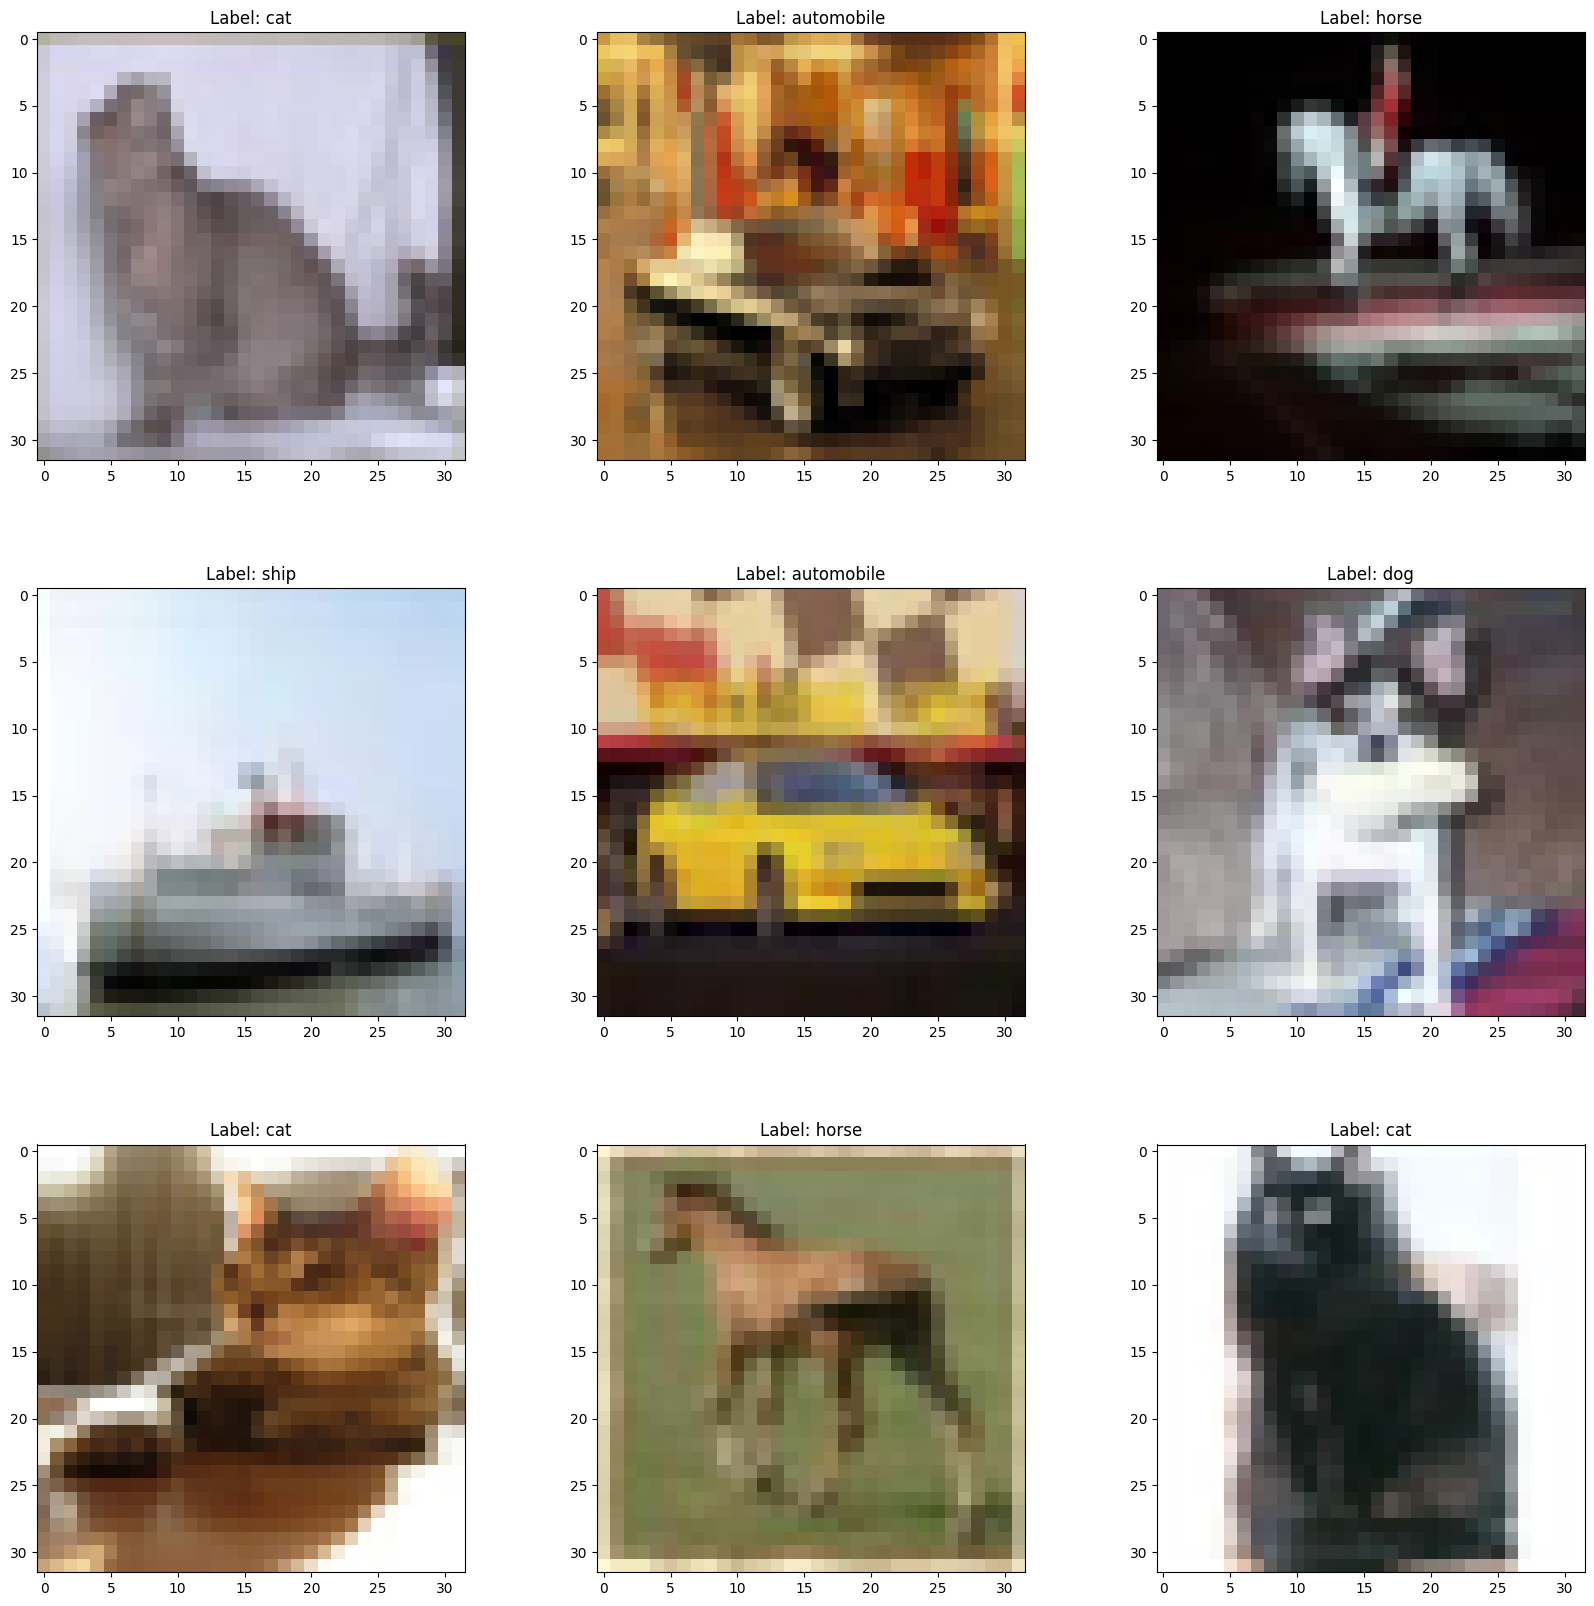

In [65]:
def display_images(batch, metadata):
    batch_images = batch[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
    labels =  pd.DataFrame({"name": metadata[b'label_names'], 
              "id": [i for i in range(len(metadata[b'label_names']))]}).set_index('id')

    num_img = 9

    fig, axes = plt.subplots(3, 3, figsize=(20,20))
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i in range(num_img):
        idx = np.random.randint(metadata[b'num_cases_per_batch'])
        ax = axes[i // 3, i % 3]
        ax.imshow(batch_images[idx])
        ax.set_title(f"Label: {labels.loc[batch[b'labels'][idx]].values[0].decode('ascii')}")
    plt.show()

display_images(batch1,meta)

## Quick EDA (Rerpartition of classes, etc...)

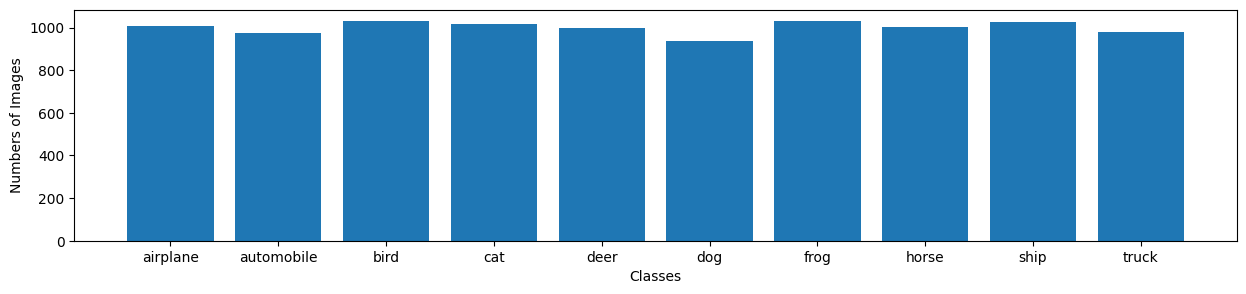

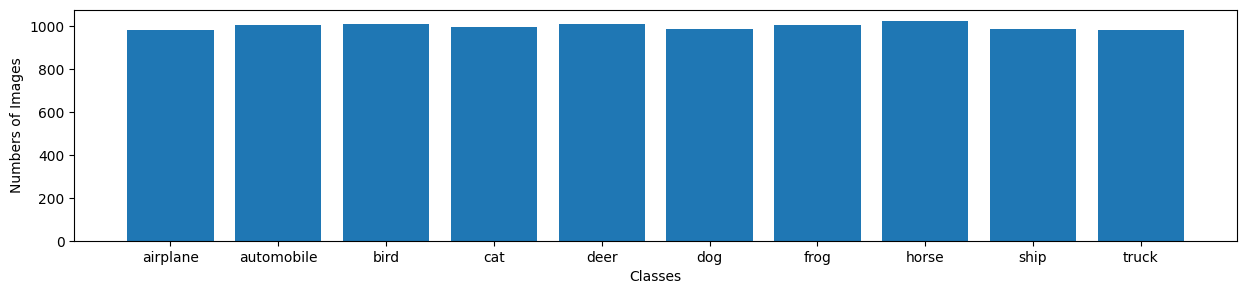

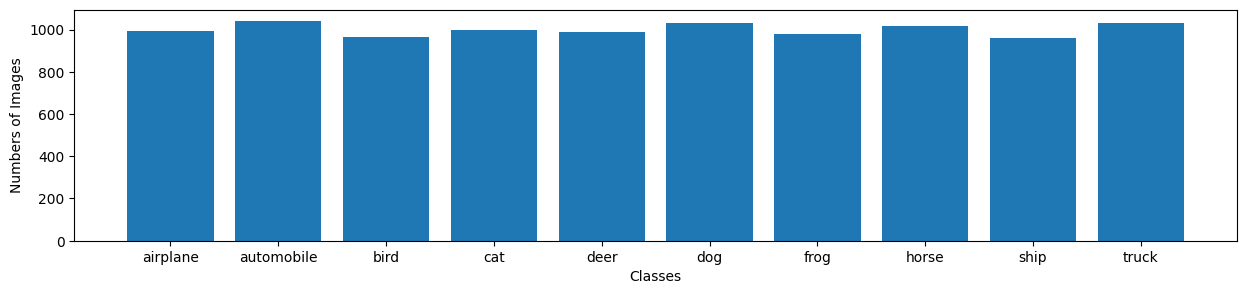

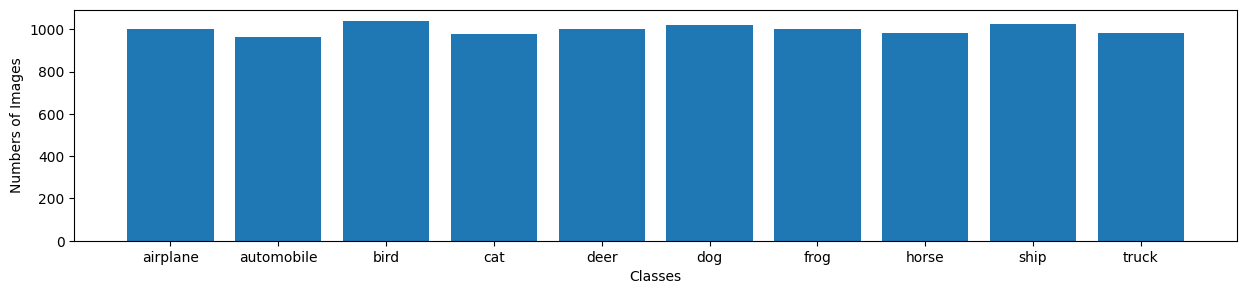

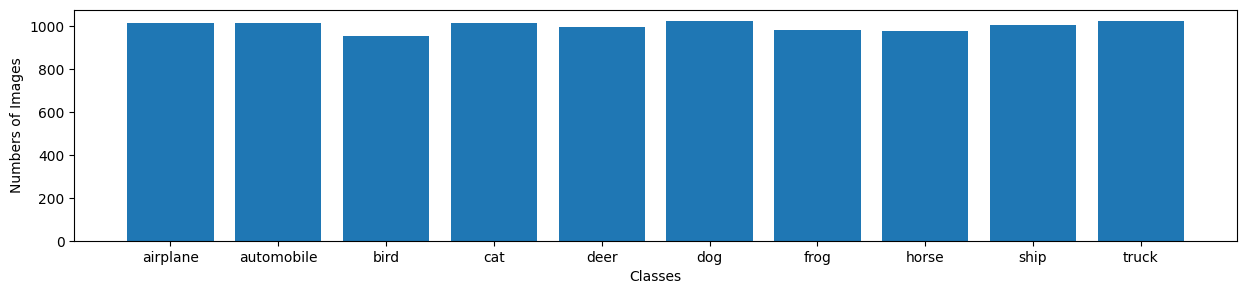

In [80]:
labels = pd.DataFrame({"name": [ i.decode('ascii') for i in meta[b'label_names']], 
            "id": [i for i in range(len(meta[b'label_names']))]})

def repartition_one_batch(batch, meta):
    l = batch[b'labels']
    lc  = [0 for i in range(10)]
    for i in l:
        lc[i] += 1
    plt.figure(figsize=(15,3))
    plt.bar(labels['id'], lc, tick_label=labels['name'])
    plt.xlabel("Classes")
    plt.ylabel("Numbers of Images")
    plt.show()

repartition_one_batch(batch1, meta)
repartition_one_batch(unpickle("../data/data_batch_2"), meta)
repartition_one_batch(unpickle("../data/data_batch_3"), meta)
repartition_one_batch(unpickle("../data/data_batch_4"), meta)
repartition_one_batch(unpickle("../data/data_batch_5"), meta)

## Preprocess

## Training

## Dev and test 

## Fine-tune & Analysis